# Pix2Pix model for Image inpainting

### Check for GPU availability

In [58]:
import tensorflow as tf
import random
import numpy as np
import pandas as pd

gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    print("Name:", gpu.name, "  Type:", gpu.device_type)
    
random.seed(42)

Name: /physical_device:GPU:0   Type: GPU


### Imports and Image loading (pre-processing)

In [59]:
import tensorflow as tf

import os
import pathlib
import time
import datetime
import cv2

#for graphs and visualization
from matplotlib import pyplot as plt
from IPython import display

#path to dataset
PATH = "../input/photo-reconstruction/"

#hyper-parameters
IMG_WIDTH = 256
IMG_HEIGHT = 256
BUFFER_SIZE = 1000
BATCH_SIZE = 1


In [60]:
#this function will recieve two types of inputs either tensor or a string containing path to masked image
#this function will recieve path to masked image and will return masked as well as unmasked version of the image
def load(input_path):
    
    #print(type(input_path))
    
    if isinstance(input_path, tf.Tensor):
        unmasked_path = tf.strings.regex_replace(input_path, "Masked_Train", "Unmasked_Train")
    else:
        unmasked_path = input_path.replace("Masked_Train", "Unmasked_Train")
        
    #new_string will hold path to unmasked version of the image i.e. ground label
    # Read and decode an image file to a uint8 tensor using io module of tensorflow
    image = tf.io.read_file(input_path)
    masked_image = tf.io.decode_jpeg(image)
    image = tf.io.read_file(unmasked_path)
    unmasked_image = tf.io.decode_jpeg(image)


    # Convert both images to float32 tensors
    masked_image = tf.cast(masked_image, tf.float32)
    unmasked_image = tf.cast(unmasked_image, tf.float32)

    #return masked image and unmasked image
    return masked_image, unmasked_image


def normalize(masked_image, unmasked_image):
    # The purpose of this normalization is to scale the pixel values of the images to the range [-1, 1]
    # original pixel-value range: [0, 255]
    masked_image = (masked_image / 127.5) - 1 
    unmasked_image = (unmasked_image / 127.5) - 1

    return masked_image, unmasked_image

def random_crop(masked_image, unmasked_image):
    #The two images are stackedtogether along a new dimension (axis=0) using tf.stack. 

    #The function then applies a random crop using tf.image.random_crop on the stacked image. 
    #The size is given as [2, IMG_HEIGHT, IMG_WIDTH, 3], 
    #The first dimension specifies the number of images (i.e., 2), 
    #The remaining dimensions specify the height, width, and number of channels of each of the two images.
    
    stacked_image = tf.stack([masked_image, unmasked_image], axis=0) #dimesion: [2, IMG_HEIGHT, IMG_WIDTH, 3]
    cropped_image = tf.image.random_crop(stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

    return cropped_image[0], cropped_image[1]

def resize(masked_image, unmasked_image, im_height, im_width):
    #The masked_image and the unmasked_image are resized using tf.image.resize 
    #The images are resized to the specified height and width 
    #The ResizeMethod parameter is set to NEAREST_NEIGHBOR which uses the nearest pixel values in the original image to calculate the new pixel values.

    masked_image = tf.image.resize(masked_image, [im_height, im_width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    unmasked_image = tf.image.resize(unmasked_image, [im_height, im_width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    return masked_image, unmasked_image

@tf.function
def random_jitter(masked_image, unmasked_image):
    # image is resized to 286x286
    masked_image, unmasked_image = resize(masked_image, unmasked_image, 286, 286)

    # images are randomly cropped back to 256x256
    masked_image, unmasked_image = random_crop(masked_image, unmasked_image)

    #50% images are flipped left to right
    if tf.random.uniform(()) > 0.5:
        # Random mirroring
        masked_image = tf.image.flip_left_right(masked_image)
        unmasked_image = tf.image.flip_left_right(unmasked_image)

    #image with these random transformations are returned.
    #adding random transformations helps in making model robust
    return masked_image, unmasked_image

#### Load a image

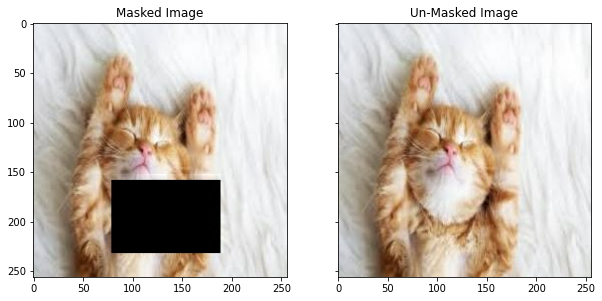

In [61]:
inp,re = load(PATH + '/Dataset/Training_Data/Cat/Masked_Train/Cat-Train (1).jpeg')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), sharey=True);
ax1.imshow(inp / 255.0);
ax1.set_title("Masked Image");

# Plot the second subplot
ax2.imshow(re / 255.0);
ax2.set_title("Un-Masked Image");



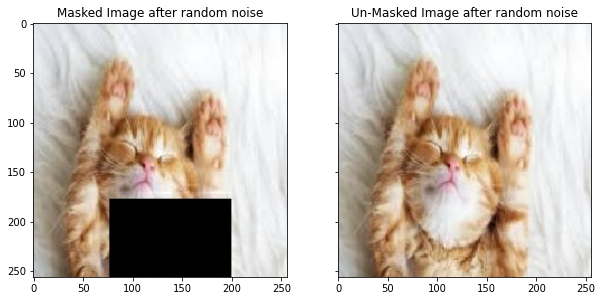

In [62]:
inp,re = load(PATH + '/Dataset/Training_Data/Cat/Masked_Train/Cat-Train (1).jpeg')
inp,re = random_jitter(inp,re)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), sharey=True);

ax1.imshow(inp / 255.0);
ax1.set_title("Masked Image after random noise");

# Plot the second subplot
ax2.imshow(re / 255.0);
ax2.set_title("Un-Masked Image after random noise");


#### Data pre-processing and augmenting functions
These set of functions aims to create training dataset by importing images, applying transformations upon them. The 7000 training image set is further expanded to 35000 training image set by applying 4 transformations of every image to make the model for robust and learn better.

In [63]:
def load_training_set(image_file):
    #load masked and unmasked image corresponding to image file path and 
    #add random noise to the image and normalize the masked and unmasked version of the image
    masked_image, unmasked_image = load(image_file)
    masked_image, unmasked_image = random_jitter(masked_image, unmasked_image)
    masked_image, unmasked_image = normalize(masked_image, unmasked_image)

    return masked_image, unmasked_image

def load_training_set_90(image_file):
    #load masked and unmasked image corresponding to image file path and rotate them by 90 degree
    #add random noise to the image and normalize the masked and unmasked version of the image
    masked_image, unmasked_image = load(image_file)
    masked_image = tf.image.rot90(masked_image, 1)
    unmasked_image = tf.image.rot90(unmasked_image, 1)
    masked_image, unmasked_image = random_jitter(masked_image, unmasked_image)
    masked_image, unmasked_image = normalize(masked_image, unmasked_image)

    return masked_image, unmasked_image

def load_training_set_180(image_file):
    #load masked and unmasked image corresponding to image file path and rotate them by 180 degree
    #add random noise to the image and normalize the masked and unmasked version of the image
    masked_image, unmasked_image = load(image_file)
    masked_image = tf.image.rot90(masked_image, 2)
    unmasked_image = tf.image.rot90(unmasked_image, 2)
    masked_image, unmasked_image = random_jitter(masked_image, unmasked_image)
    masked_image, unmasked_image = normalize(masked_image, unmasked_image)

    return masked_image, unmasked_image

def load_training_set_270(image_file):
    #load masked and unmasked image corresponding to image file path and rotate them by 270 degree
    #add random noise to the image and normalize the masked and unmasked version of the image
    masked_image, unmasked_image = load(image_file)
    masked_image = tf.image.rot90(masked_image, 3)
    unmasked_image = tf.image.rot90(unmasked_image, 3)
    masked_image, unmasked_image = random_jitter(masked_image, unmasked_image)
    masked_image, unmasked_image = normalize(masked_image, unmasked_image)

    return masked_image, unmasked_image

def load_training_set_flip(image_file):
    #load masked and unmasked image corresponding to image file path and flip them
    #add random noise to the image and normalize the masked and unmasked version of the image
    masked_image, unmasked_image = load(image_file)
    masked_image = tf.image.flip_left_right(masked_image)
    unmasked_image = tf.image.flip_left_right(unmasked_image)
    masked_image, unmasked_image = random_jitter(masked_image, unmasked_image)
    masked_image, unmasked_image = normalize(masked_image, unmasked_image)

    return masked_image, unmasked_image


In [64]:
def load_test_set(image_file):
    masked_image, unmasked_image = load(image_file)
    masked_image, unmasked_image = resize(masked_image, unmasked_image, IMG_HEIGHT, IMG_WIDTH)
    masked_image, unmasked_image = normalize(masked_image, unmasked_image)

    return masked_image

#### Load training image and apply transformations to form training dataset

In [65]:
train_file_path = [  PATH + 'Dataset/Training_Data/Cat/Masked_Train/*.jpg',
                     PATH + 'Dataset/Training_Data/Cat/Masked_Train/*.jpeg',
                     PATH + 'Dataset/Training_Data/Cat/Masked_Train/*.png',
                     PATH + 'Dataset/Training_Data/Dog/Masked_Train/*.jpg',
                     PATH + 'Dataset/Training_Data/Dog/Masked_Train/*.jpeg',
                     PATH + 'Dataset/Training_Data/Dog/Masked_Train/*.png',
                     PATH + 'Dataset/Training_Data/Elephant/Masked_Train/*.jpg',
                     PATH + 'Dataset/Training_Data/Elephant/Masked_Train/*.jpeg',
                     PATH + 'Dataset/Training_Data/Elephant/Masked_Train/*.png',
                     PATH + 'Dataset/Training_Data/Tiger/Masked_Train/*.jpg',
                     PATH + 'Dataset/Training_Data/Tiger/Masked_Train/*.jpeg',
                     PATH + 'Dataset/Training_Data/Tiger/Masked_Train/*.png' ]

train_file_list = tf.data.Dataset.list_files(train_file_path)
train_dataset   = train_file_list.map(load_training_set, num_parallel_calls=tf.data.AUTOTUNE)
print("Number of images in training set originally: ", len(train_dataset))

#apply set of transformations to augment dataset
train_dataset_1 = train_file_list.map(load_training_set_90, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset_2 = train_file_list.map(load_training_set_180, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset_3 = train_file_list.map(load_training_set_270, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset_4 = train_file_list.map(load_training_set_flip, num_parallel_calls=tf.data.AUTOTUNE)

#concatenate all the dataset
train_dataset = train_dataset.concatenate(train_dataset_1)
train_dataset = train_dataset.concatenate(train_dataset_2)
train_dataset = train_dataset.concatenate(train_dataset_3)
train_dataset = train_dataset.concatenate(train_dataset_4)

#shuffle the dataset and create batches
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)



Number of images in training set originally:  7000


In [66]:
print("Total length of the training dataset",len(train_dataset))

Total length of the training dataset 35000


# **Pix2Pix Architecure**
<ul>
<li>In 2016, a group of scholars led by <b><i>Phillip Isola, at Berkeley AI Research (BAIR)</b></i> published the paper titled <b><i>Image-to-Image Translation with Conditional Adversarial Networks</b></i> and later presented it at CVPR 2017. This paper has gathered more than 7400 citations so far! a new model Pix2Pix was proposed which was a type of Conditional GAN (CGAN), (an extension of the DCGAN architecture).
</li>

<li>
It consists  of two networks: the <b><i>generator and the discriminator</b></i>. Both trained in tandem, the generator tries to mimic the real data distribution, while the discriminator network learnes to classify real from fake (generated). 
</li>

<li>
In pix2pix:
<ol>
    <li> An image is input to the generator network, which then outputs a translated version.</li>
    <li> The discriminator is a conditional discriminator, which is fed a real or fake (generated) image  that has been conditioned on the same input image that was fed to the generator. </li>
    <li> The goal of the discriminator is to classify whether the pair of images is real (from the dataset) or fake (generated). </li>
    <li> The final objective of the Pix2Pix GAN remains  the same as that of all the GANs. It too seeks to fool the discriminator, such that the generator learns to translate images perfectly</li>
    </ol>
 </ul>


* Since both input and output is an image, pix2pix uses autoencoders i.e. it has both encoder and decoder networks. The encoder part of the autoencoder is used to encode the input image into a lower-dimensional representation, and the decoder part of the autoencoder is used to reconstruct the output image from the encoded representation. This allows the network to learn a mapping between input images and output images, by minimizing the difference between the reconstructed output images and the ground truth output images.
<br>
<br>
<center>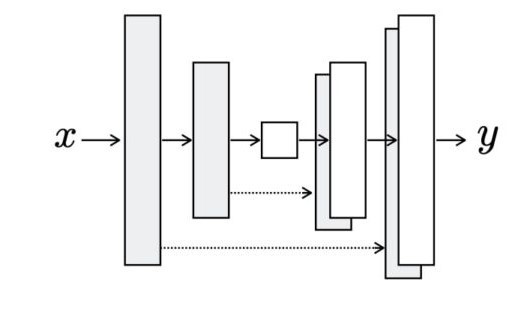</center>

* Each block in the encoder is: Convolution -> Batch normalization -> Leaky ReLU
* Each block in the decoder is: Transposed convolution -> Batch normalization -> Dropout (applied to the first 3 blocks) -> ReLU
* There are skip connections between the encoder and decoder 

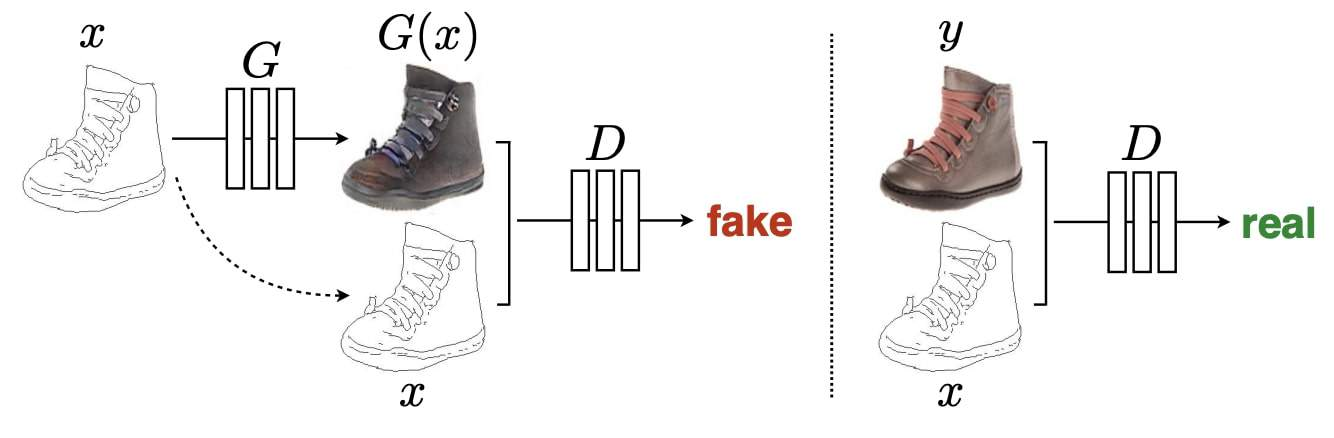

### Generator In pix2pix model
The generator contains with the downsampler and the upsampler:

In [67]:
OUTPUT_CHANNELS = 3

def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                                      kernel_initializer=initializer, use_bias=False))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

    result.add(tf.keras.layers.LeakyReLU())

    return result

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                               padding='same',
                                               kernel_initializer=initializer,
                                               use_bias=False))

    result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result

In [68]:
def Generator():
    inputs = tf.keras.layers.Input(shape=[256, 256, 3])

    down_stack = [
        downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
        downsample(128, 4),  # (batch_size, 64, 64, 128)
        downsample(256, 4),  # (batch_size, 32, 32, 256)
        downsample(512, 4),  # (batch_size, 16, 16, 512)
        downsample(512, 4),  # (batch_size, 8, 8, 512)
        downsample(512, 4),  # (batch_size, 4, 4, 512)
        downsample(512, 4),  # (batch_size, 2, 2, 512)
        downsample(512, 4),  # (batch_size, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
        upsample(512, 4),  # (batch_size, 16, 16, 1024)
        upsample(256, 4),  # (batch_size, 32, 32, 512)
        upsample(128, 4),  # (batch_size, 64, 64, 256)
        upsample(64, 4),  # (batch_size, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0.0, 0.02)
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS,
                                           4,
                                           strides=2,
                                           padding="same",
                                           kernel_initializer=initializer,
                                           activation="tanh")  # (batch_size, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

generator = Generator()

#### Generator loss 
* It contains adversarial loss (i.e. binary cross entropy loss) and L1 loss ( which acts as a regularization term, penalizing the generator if the reconstruction quality of the translated image is not similar to the target image).

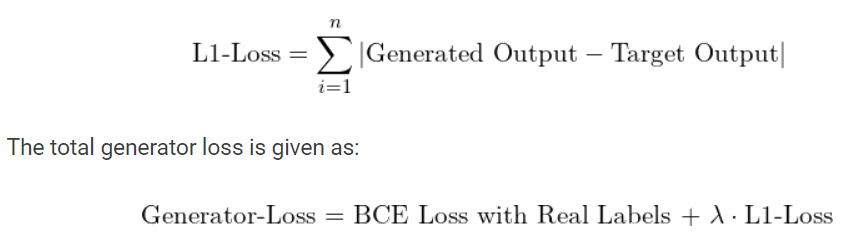

In [69]:
LAMBDA = 1000
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

    # Mean absolute error
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

    total_gen_loss = gan_loss + (LAMBDA * l1_loss)

    return total_gen_loss, gan_loss, l1_loss

#### Visualize generator output

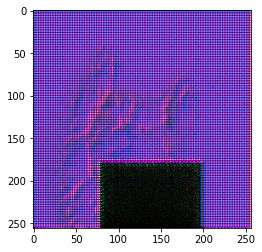

In [70]:
gen_output = generator(inp[tf.newaxis, ...], training=False)
plt.imshow(gen_output[0, ...])

### Build discriminator
* The Pix2Pix Discriminator classifies an input as real (sampled from the dataset) or fake (produced by generator).

* Pix2Pix discriminator is also called a PatchGAN,as it outputs a tensor of values (30×30) instead of a scalar value in the range [0,1] as seen in previous GAN architectures. 

* Unlike the traditional GAN model that uses a CNN with a single output to classify images, the Pix2Pix model uses a PatchGAN to classify patches (70×70) of an input image as real or fake, rather than considering the entire image at one go.

***Architectural details***

* A standard Convolution-Batch Normalization-ReLU blocks of layers is used.
* But the number of layers is configured such that the effective receptive field of each output of the network maps to a specific size in the input image. 
* The network outputs a single feature map of real/fake predictions that can be averaged to give a single score (loss value). 


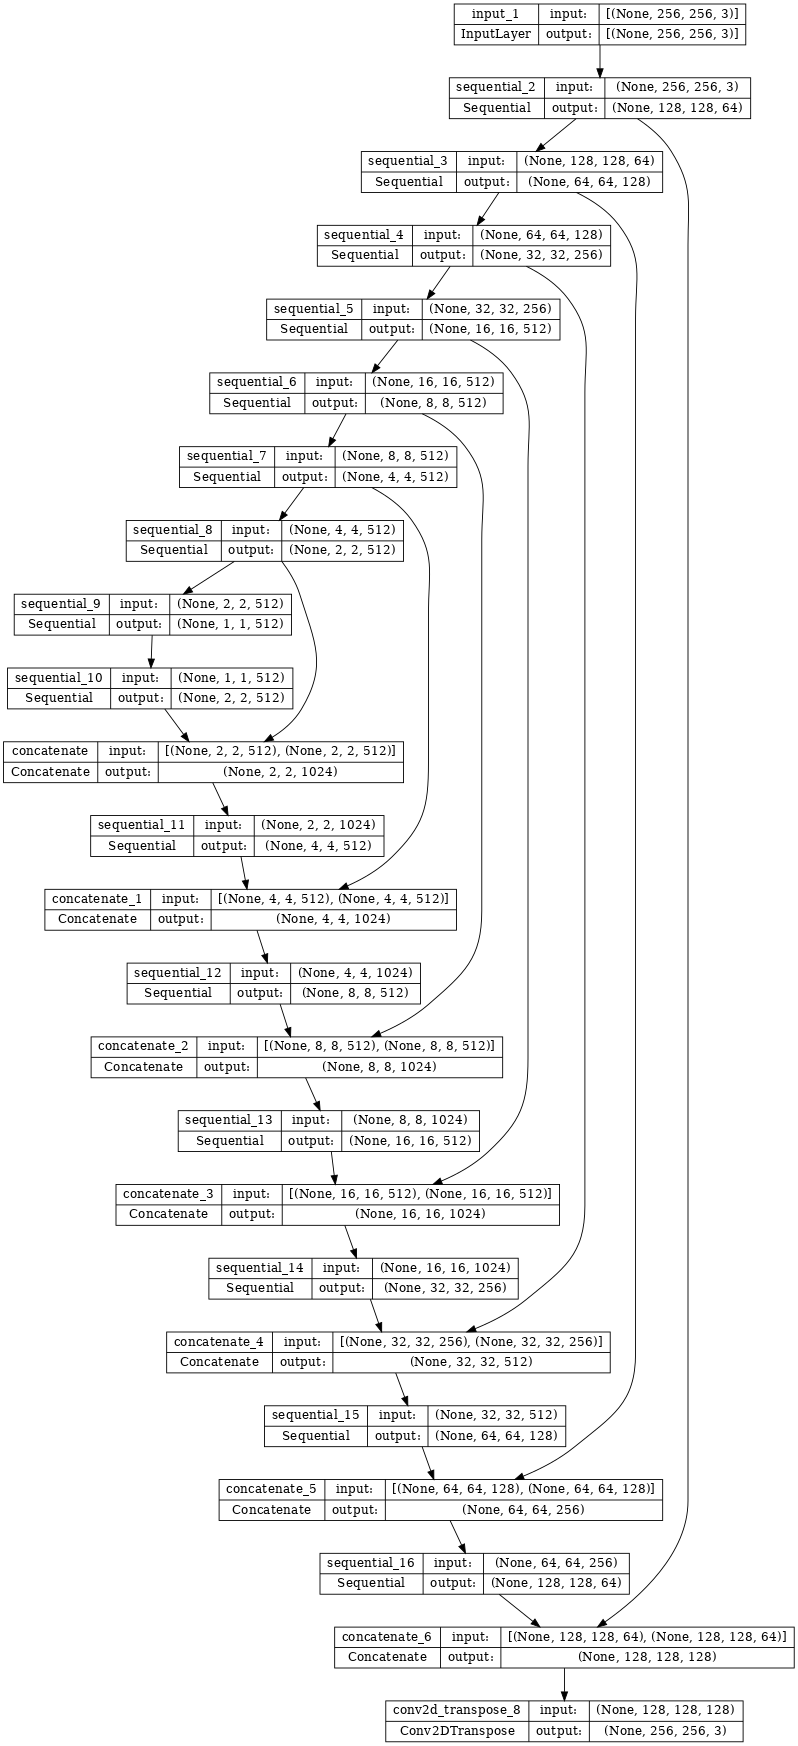

### Pix2Pix Loss function:

* The discriminator’s job remains unchanged, but the generator is tasked to not only fool the discriminator but also to be near the ground-truth output in an L2 sense. We also explore this option, using L1 distance rather than L2 as L1 encourages less blurring.

* The Pix2Pix discriminator network is trained with the Adversarial Loss (Binary Cross-Entropy (BCE)). The discriminator’s objective here is to minimize the likelihood of a negative log identifying real and fake images.

* Real labels are used to train the generator network with the adversarial loss (BCE Loss) for generated images. It also has an additional loss, i.e., an L1 loss, which is used to minimize the error. 

In [71]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
    tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

    x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 256, 256, channels*2)

    down1 = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
    down2 = downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)
    down3 = downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
    conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                  kernel_initializer=initializer,
                                  use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

    last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                  kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

    return tf.keras.Model(inputs=[inp, tar], outputs=last)

discriminator = Discriminator()

In [72]:
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss

#### Visualise the output of discriminator

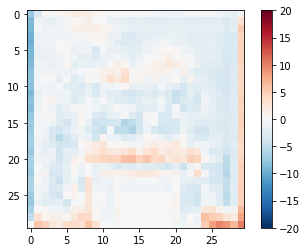

In [73]:
disc_out = discriminator([inp[tf.newaxis, ...], gen_output], training=False)
plt.imshow(disc_out[0, ..., -1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()

# Define optimizer and checkpoint

In [74]:
generator_optimizer = tf.keras.optimizers.Adam(3e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(3e-4, beta_1=0.5)

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

### Make predictions

In [75]:
#given model, masked and unmasked versions of the image
#the function prints the masked version , unmasked version and the prediction of the model
#this function will be used to visualise the predictions on training set
def generate_images_train(model, masked, unmasked):
    prediction = model(masked, training=True)
    plt.figure(figsize=(15, 15))

    display_list = [masked[0], unmasked[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

In [76]:
#given model and masked version of the image
#the function prints the masked version  and the prediction of the model
#this function will be used to visualise the predictions on testing set
def generate_images_test(model, masked):
    prediction = model(masked, training=True)
    plt.figure(figsize=(15, 15))

    display_list = [masked[0], prediction[0]]
    title = ['Input Image','Predicted Image']

    for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

### Training Loop Defination

In [77]:
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

#the function calculates the loss after propagating the input image thorugh the 
#generator and discriminator, calculate gradients wrt loss and then back propagate the
#loss to update the parameters. The loss details are written in the log file
@tf.function
def train_step(input_image, target, step):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)

        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)

        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(gen_total_loss,
                                      generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss,
                                           discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients,
                                      generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                          discriminator.trainable_variables))

    with summary_writer.as_default():
        tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//1000)
        tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step//1000)
        tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step//1000)
        tf.summary.scalar('disc_loss', disc_loss, step=step//1000)
    
    return gen_total_loss, gen_gan_loss, gen_l1_loss, disc_loss


In [78]:
#for plotting variation of loss with every 10 epochs
gen_total = []
gen_gan = []
gen_l1 = []
disc =[]
x = []

In [79]:
#the function calls the train_setp function steps number of times
#will be used to train the model for steps number of epochs
def fit(train_ds, steps):
    sample_masked, sample_unmasked = next(iter(train_ds.take(1)))
    start = time.time()

    for num_epoch, (masked_image, unmasked_image) in train_ds.repeat().take(steps).enumerate():
        if (num_epoch) % 1000 == 0:
            display.clear_output(wait=True)

            if num_epoch != 0:
                print(f"Time taken for 1000 steps: {time.time()-start:.2f} sec\n")

            start = time.time()

            generate_images_train(generator, sample_masked, sample_unmasked)
            print(f"Step: {num_epoch//1000}k")
            
        gen_total_loss, gen_gan_loss, gen_l1_loss, disc_loss = train_step(masked_image, unmasked_image, num_epoch)
        if (num_epoch + 1) % 10 == 0:
            x.append(num_epoch+1)
            gen_total.append(gen_total_loss)
            gen_gan.append(gen_gan_loss)
            gen_l1.append(gen_l1_loss)
            disc.append(disc_loss)
            print(".", end="", flush=True)

Time taken for 1000 steps: 51.97 sec



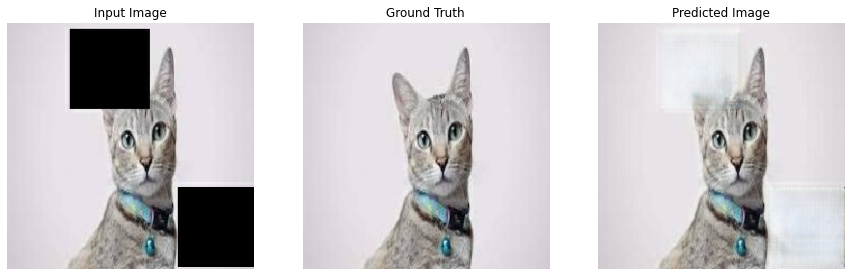

Step: 159k
....................................................................................................

In [80]:
fit(train_dataset, steps=160000)

### Plot the loss function and their variations with number of epochs 

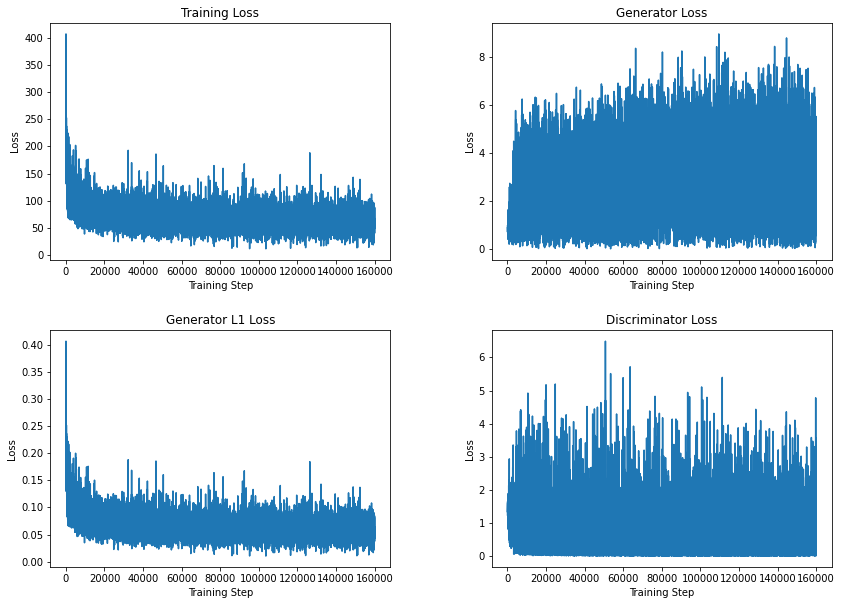

In [81]:
fig, axs = plt.subplots(2, 2, figsize=(14,10))

axs[0, 0].plot(x,gen_total)
axs[0, 0].set_title('Training Loss')
axs[0, 0].set_xlabel('Training Step')
axs[0, 0].set_ylabel('Loss')

axs[0, 1].plot(x,gen_gan)
axs[0, 1].set_title('Generator Loss')
axs[0, 1].set_xlabel('Training Step')
axs[0, 1].set_ylabel('Loss')

axs[1, 0].plot(x,gen_l1)
axs[1, 0].set_title('Generator L1 Loss')
axs[1, 0].set_xlabel('Training Step')
axs[1, 0].set_ylabel('Loss')

axs[1, 1].plot(x,disc)
axs[1, 1].set_title('Discriminator Loss')
axs[1, 1].set_xlabel('Training Step')
axs[1, 1].set_ylabel('Loss')

plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.show()


# Inferencing 
**Use the saved model from link and make predictions on test set.**

### Export model from the link

In [82]:
#generator.save('model.h5')

In [83]:
from keras.models import load_model
my_model = load_model('../input/model-gan/trial1.h5')
my_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
sequential_18 (Sequential)      (None, 128, 128, 64) 3072        input_2[0][0]                    
__________________________________________________________________________________________________
sequential_19 (Sequential)      (None, 64, 64, 128)  131584      sequential_18[0][0]              
__________________________________________________________________________________________________
sequential_20 (Sequential)      (None, 32, 32, 256)  525312      sequential_19[0][0]              
____________________________________________________________________________________________

#### View predictions of the model on some test images

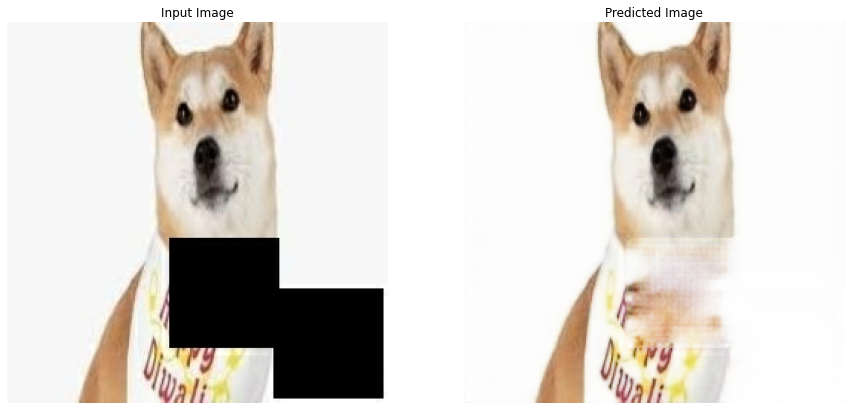

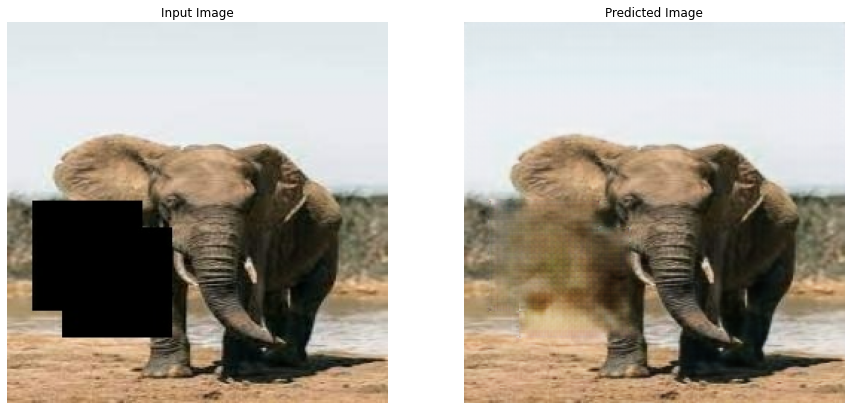

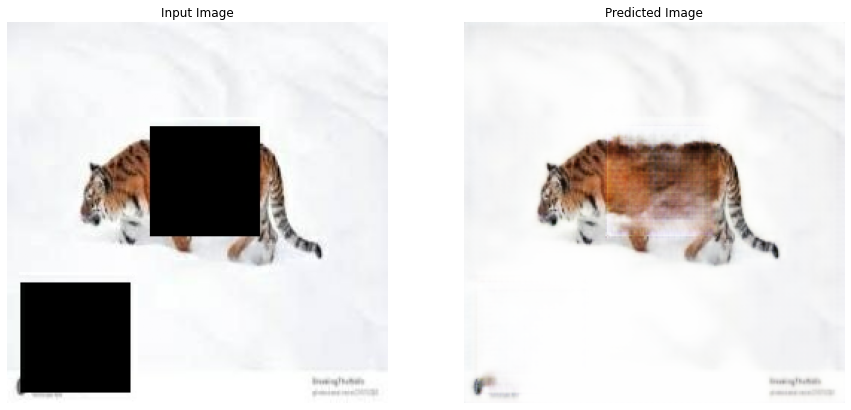

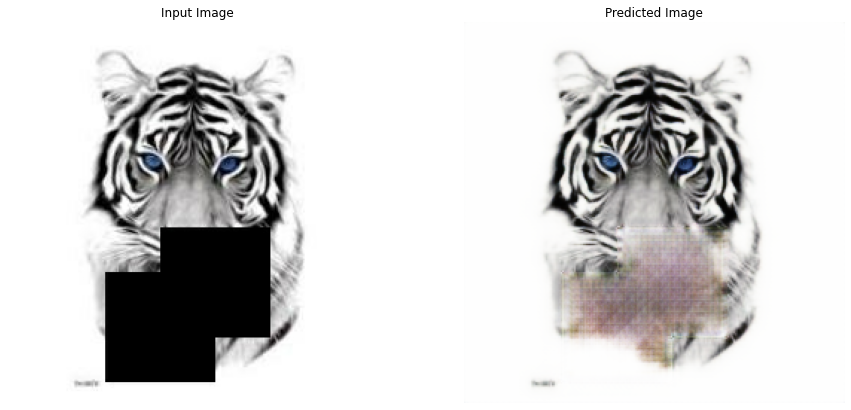

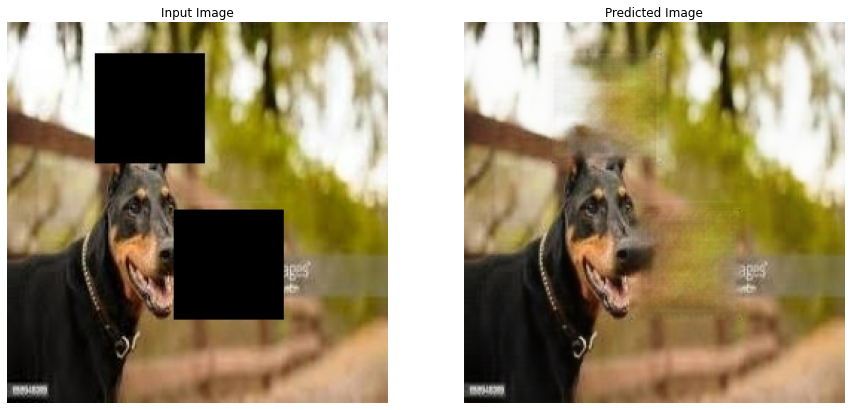

In [84]:
test = [PATH + 'Dataset/Testing_Data/*.jpg',PATH + 'Dataset/Testing_Data/*.jpeg',PATH + 'Dataset/Testing_Data/*.png']
test_dataset = tf.data.Dataset.list_files(test)
test_dataset = test_dataset.map(load_test_set, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE)


# Run the trained model on a few examples from the test set

for inp in test_dataset.take(5):
  generate_images_test(my_model, inp)

In [85]:
# Define the file path patterns for the images
import glob

paths = []
# list of file locations
for image_name in test:
    paths.extend(glob.glob(image_name))

# Sort the file names
paths = sorted(paths)
# create a DataFrame of images
image_data = {}
for image_loc in paths:
    img = load_test_set(image_loc)
    # Trim the file path to get only the image name
    image_loc = image_loc.split('/')[-1]
    image_data[image_loc] = img

print("Loaded {} images".format(len(image_data)))

Cleanup called...
Cleanup called...


Loaded 200 images


In [86]:
BOUNDING_SIZE = 75
df = pd.read_csv(PATH + 'Dataset/Testing_Data/masked_info.csv')
df.head()

,Unnamed: 0,filename,box1_row,box1_col,box2_row,box2_col
0,0,Tiger (1024).jpeg,58,27,104,15
1,1,Elephant-Train (1195).jpeg,92,38,98,94
2,2,Tiger (980).jpeg,12,116,42,33
3,3,Elephant-Train (1842).jpeg,2,77,174,174
4,4,Dog-Train (1753).jpeg,52,75,84,160


In [87]:
# Create a new csv file for predictions
import csv

with open('./submission.csv', 'w') as submission_csv:
    file_field = ['filename_box_pixel','Value']
    writer = csv.writer(submission_csv)
    writer.writerow(file_field)
    
    # Iterate through the dataframe and apply predictions to the images
    for index, row in df.iterrows():
        
        img = image_data[row['filename']]
        img = tf.expand_dims(img, 0)
        bounding_boxes = [[row['box1_row'], row['box1_col']],[row['box2_row'], row['box2_col']]]
        
        #get the image, get the bounding box info from csv and then pass 
        #the image to the model to get prediction
        prediction = my_model(img, training=True)

        preds = np.array(prediction[0])
        out_str = row['filename']
        for k in range(2):
            temp_str = out_str + "_box" + str(k+1)
            # get pixel values of the bounding box and get predictions of that pixel
            for i in range(BOUNDING_SIZE):
                x = bounding_boxes[k][0] + i
                temp_str1 = temp_str + '_' + str(x)
                for j in range(BOUNDING_SIZE):
                    y = bounding_boxes[k][1] + j
                    temp_str2 = temp_str1 + '_' + str(y)
                    for p in range(3):
                        temp_str3 = temp_str2 + '_' + str(p)
                        writer.writerow([temp_str3, preds[x][y][2-p]*0.5+0.5])
        print(row['filename'])


    

Tiger (1024).jpeg
Elephant-Train (1195).jpeg
Tiger (980).jpeg
Elephant-Train (1842).jpeg
Dog-Train (1753).jpeg
Cat-Train (1374).jpeg
Cat-Train (61).jpeg
Tiger (1037).jpeg
Tiger (1477).jpeg
Cat-Train (24).jpg
Elephant-Train (40).jpeg
Tiger (1115).jpeg
Elephant-Train (1127).jpeg
Cat-Train (1547).jpeg
Elephant-Train (1183).jpeg
Dog-Train (651).jpeg
Cat-Train (1387).jpeg
Tiger (2256).jpeg
Tiger (766).jpeg
Tiger (1353).jpeg
Dog-Train (43).jpeg
Elephant-Train (584).jpeg
Cat-Train (1576).jpeg
Elephant-Train (1761).jpeg
Dog-Train (1640).jpeg
Dog-Train (42).jpg
Dog-Train (151).jpeg
Dog-Train (1536).jpeg
Elephant-Train (216).jpeg
Tiger (1534).jpeg
Elephant-Train (633).jpeg
Cat-Train (760).jpeg
Cat-Train (687).jpeg
Cat-Train (1457).jpeg
Cat-Train (24).jpeg
Dog-Train (46).jpg
Elephant-Train (382).jpeg
Dog-Train (875).jpeg
Cat-Train (1525).jpeg
Elephant-Train (64).jpeg
Cat-Train (712).jpeg
Tiger (2000).jpeg
Cat-Train (1354).jpeg
Cat-Train (167).jpeg
Elephant-Train (461).jpeg
Cat-Train (1702).jpeg
C